In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv("compressed_banding_videos.csv")
df2 = pd.read_csv("compressed_banding_videos.csv", index_col=2)

In [14]:
cambiScores = df.iloc[:,9]
vmafScores = df.iloc[:,10]
SIScores = df.iloc[:,14]
TIScores = df.iloc[:,15]

In [15]:
vidRefNames = df.loc[:,"Ref"]
uniqueRefNames = pd.unique(vidRefNames)
# train contains list of video names reserved for the test dataset, and vice versa
train, test = train_test_split(uniqueRefNames,test_size=0.1,shuffle=True,random_state=0)
trainDF = df2.drop(test,axis=0)
#trainDF.to_csv("trainVideoSet.csv")
testDF = df2.drop(train,axis=0)
#testDF.to_csv("testVideoSet.csv")

In [16]:
print("No. of reference videos in train set: ",train.size)
print("No. of reference videos in Test set: ",test.size)

No. of reference videos in train set:  221
No. of reference videos in Test set:  25


In [17]:
cambiScoresTrain = trainDF.loc[:,'CAMBI']
vmafScoresTrain = trainDF.loc[:,'VMAF']
SIScoresTrain = trainDF.loc[:,'SI']
TIScoresTrain = trainDF.loc[:,'TI']

In [18]:
cambiScoresTest = testDF.loc[:,'CAMBI']
vmafScoresTest = testDF.loc[:,'VMAF']
SIScoresTest = testDF.loc[:,'SI']
TIScoresTest = testDF.loc[:,'TI']

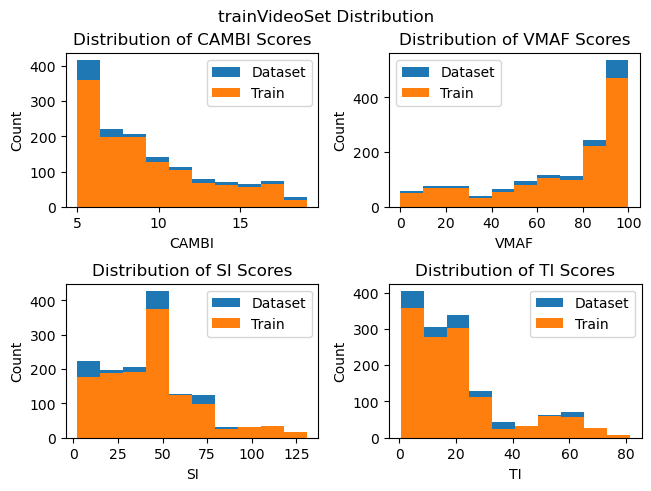

In [19]:
fig2 = plt.figure(constrained_layout=True)
Gridspec = gridspec.GridSpec(nrows=2,ncols=2,figure=fig2)

subfigure_1 = fig2.add_subfigure(Gridspec[0,0])
subplots_1 = subfigure_1.subplots(1,1)
subplots_1.hist(cambiScores)
subplots_1.hist(cambiScoresTrain)
subplots_1.set_xlabel("CAMBI"); subplots_1.set_ylabel("Count")
subplots_1.legend(["Dataset","Train"])
subplots_1.set_title("Distribution of CAMBI Scores")

subfigure_2 = fig2.add_subfigure(Gridspec[0,1])
subplots_2 = subfigure_2.subplots(1,1)
subplots_2.hist(vmafScores)
subplots_2.hist(vmafScoresTrain)
subplots_2.set_xlabel("VMAF"); subplots_2.set_ylabel("Count")
subplots_2.legend(["Dataset","Train"])
subplots_2.set_title("Distribution of VMAF Scores")

subfigure_3 = fig2.add_subfigure(Gridspec[1,0])
subplots_3 = subfigure_3.subplots(1,1)
subplots_3.hist(SIScores)
subplots_3.hist(SIScoresTrain)
subplots_3.set_xlabel("SI"); subplots_3.set_ylabel("Count")
subplots_3.legend(["Dataset","Train"])
subplots_3.set_title("Distribution of SI Scores")

subfigure_4 = fig2.add_subfigure(Gridspec[1,1])
subplots_4 = subfigure_4.subplots(1,1)
subplots_4.hist(TIScores)
subplots_4.hist(TIScoresTrain)
subplots_4.set_xlabel("TI"); subplots_4.set_ylabel("Count")
subplots_4.legend(["Dataset","Train"])
subplots_4.set_title("Distribution of TI Scores")

fig2.suptitle("trainVideoSet Distribution")

plt.show()

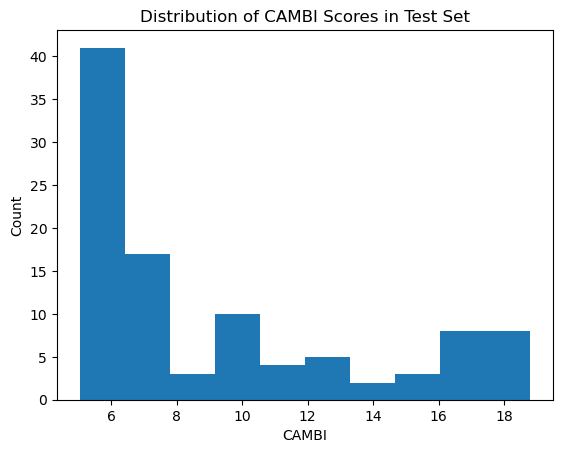

In [5]:
testDF = pd.read_csv("testVideoSet.csv")
cambiScoresTest = testDF.loc[:,'CAMBI']
bbandScoresTest = testDF.loc[:,'BBAND']
filteredbbandScoresTest = testDF.loc[:,'BBAND(Adaband)']
plt.hist(cambiScoresTest)
plt.title("Distribution of CAMBI Scores in Test Set")
plt.xlabel("CAMBI"); plt.ylabel("Count")
plt.show()

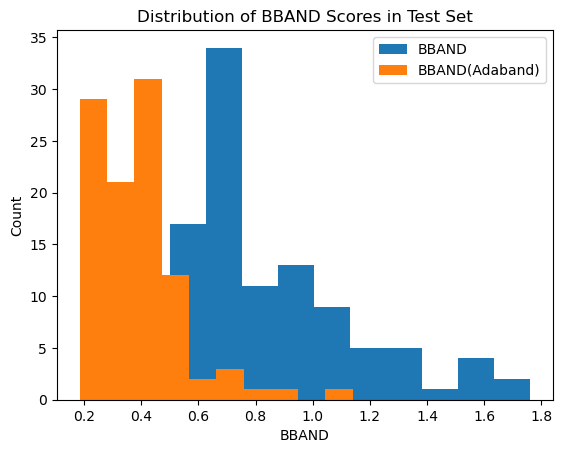

In [7]:
plt.hist(bbandScoresTest)
plt.hist(filteredbbandScoresTest)
plt.title("Distribution of BBAND Scores in Test Set")
plt.legend(["BBAND","BBAND(Adaband)"])
plt.xlabel("BBAND"); plt.ylabel("Count")
plt.show()

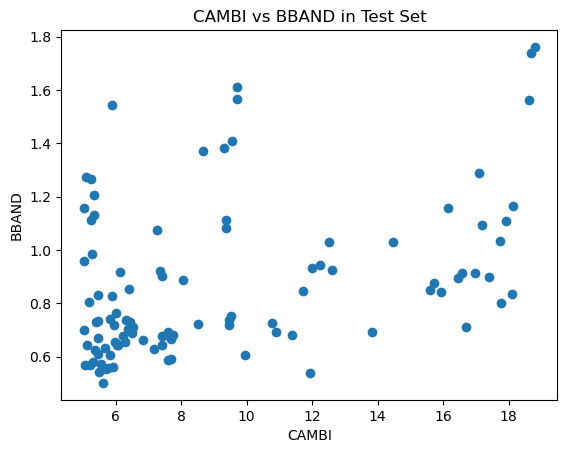

In [4]:
plt.scatter(cambiScoresTest,bbandScoresTest)
plt.title("CAMBI vs BBAND in Test Set")
plt.xlabel("CAMBI"); plt.ylabel("BBAND")
plt.show()

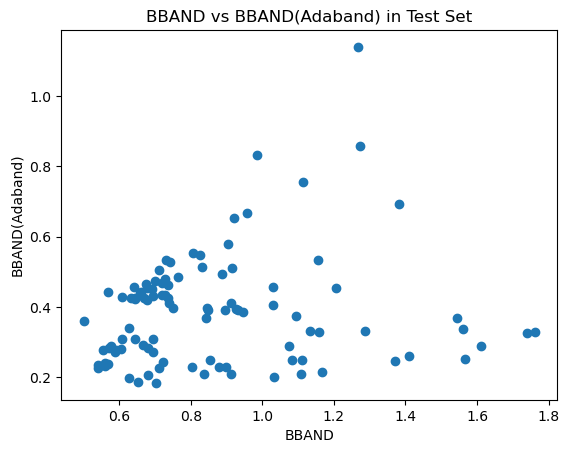

In [8]:
# Scatter plot of BBABD vs BBAND(Adaband) in test set
plt.scatter(bbandScoresTest,filteredbbandScoresTest)
plt.title("BBAND vs BBAND(Adaband) in Test Set")
plt.xlabel("BBAND"); plt.ylabel("BBAND(Adaband)")
plt.show()
# This shows the effect of the filtering on the BBAND scores